In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [5]:
SEQ_LEN = 128
W, H = 40, 40

def data_input():
    for (d, c), (f, g) in pong.games_generator(W, H, SEQ_LEN):
        yield (d, c), (f,)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32,)),
).batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [6]:
class Model:
    INTERNAL_SIZE = 32

    def project_game_init(self, x):
        self.project_state = tf.keras.layers.Dense(
            Model.INTERNAL_SIZE,
            name='project_state',
            activation='tanh'
        )
        self.project_activation = tf.keras.layers.Dense(
            Model.INTERNAL_SIZE,
            name='project_activation',
            activation='tanh'
        )

        return self.project_state(x), self.project_activation(x)

    def rollout(self, initial_state, user_input):
        self.lstm = tf.keras.layers.LSTM(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            stateful=False,
            name='lstm',
            activation='relu'
        )
        self.gru = tf.keras.layers.GRU(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='gru',
            activation='relu'
        )
        x = self.lstm(user_input, initial_state=initial_state)
        x = self.gru(x)

        return x

    def render(self, memory):
        self.renderer = tf.keras.layers.Dense(W * H, activation='sigmoid', name='frame_matrix')
        self.reshaper = tf.keras.layers.Reshape((-1, W, H), name='frame_vector')

        return self.reshaper(self.renderer(memory))

    def __init__(self):
        game_init = tf.keras.layers.Input(shape=(1), name='game_init')
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input')

        initial_state = self.project_game_init(game_init)
        rollout_memory = self.rollout(initial_state, user_input)
        frame = self.render(rollout_memory)

        self.net = tf.keras.Model([game_init, user_input], [frame])

        self.net.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['mse', 'accuracy']
        )

In [7]:
model = Model()
model.net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
project_state (Dense)           (None, 32)           64          game_init[0][0]                  
__________________________________________________________________________________________________
project_activation (Dense)      (None, 32)           64          game_init[0][0]                  
______________________________________________________________________________________________

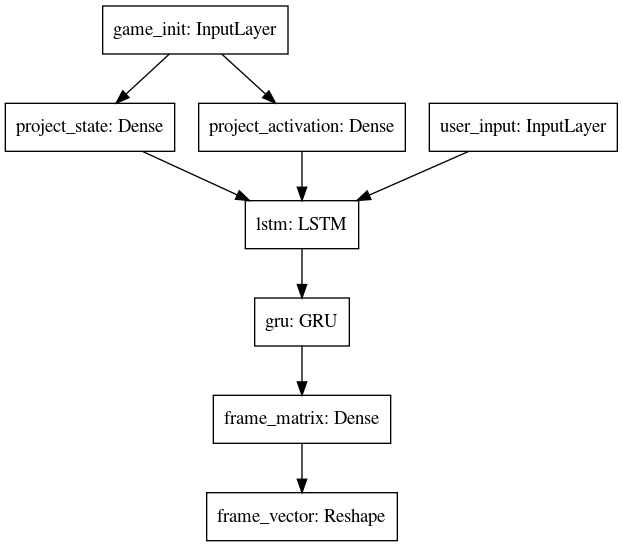

In [8]:
tf.keras.utils.plot_model(model.net, to_file='model.png')

In [9]:
frame_nums = [1, 4, 8, 16, 32, 64, 127]

class PlotCallback(tf.keras.callbacks.Callback):
    def plot_pairwise_frames(self, frame_nums):
        X, Y = list(make_dataset(1).take(1))[0]
        (directions, controls), (frames,) = X, Y
        pred_frames = model.net.predict([directions, controls])

        plot_size = 2
        num_imgs = len(frame_nums)
        fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

        for i, f in enumerate(frame_nums):
            l, r = (axs[0, i], axs[1, i])

            l.imshow(frames[0, f], cmap='bwr')
            r.imshow(pred_frames[0, f], cmap='bwr')

            l.set_xticklabels([])
            r.set_xticklabels([])
            l.set_yticklabels([])
            r.set_yticklabels([])

        fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    def on_epoch_begin(self, batch, logs=None):
        self.plot_pairwise_frames(frame_nums)
        plt.show()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


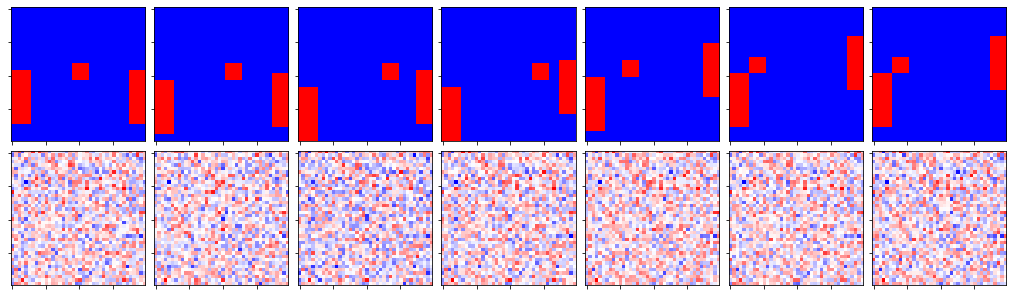

Epoch 1/2500
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100/100 [==============================] - 42s 423ms/step - loss: 1.0624 - mean_squared_error: 0.1460 - acc: 0.8837 - val_loss: 1.4730 - val_mean_squared_error: 0.1050 - val_acc: 0.8967


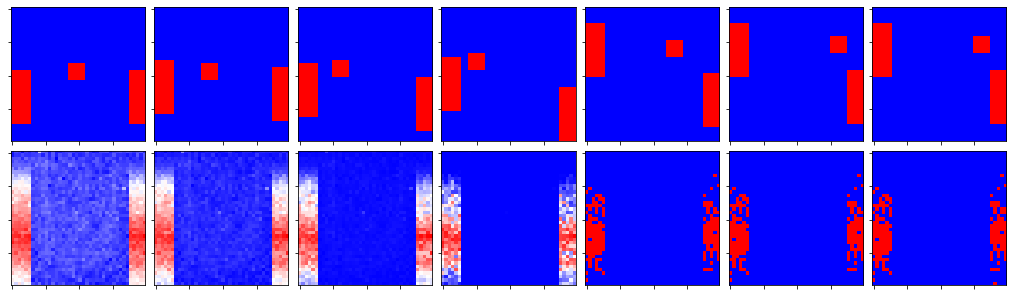

Epoch 2/2500
100/100 [==============================] - 57s 566ms/step - loss: 1.4685 - mean_squared_error: 0.1031 - acc: 0.8978 - val_loss: 1.5297 - val_mean_squared_error: 0.1067 - val_acc: 0.8935


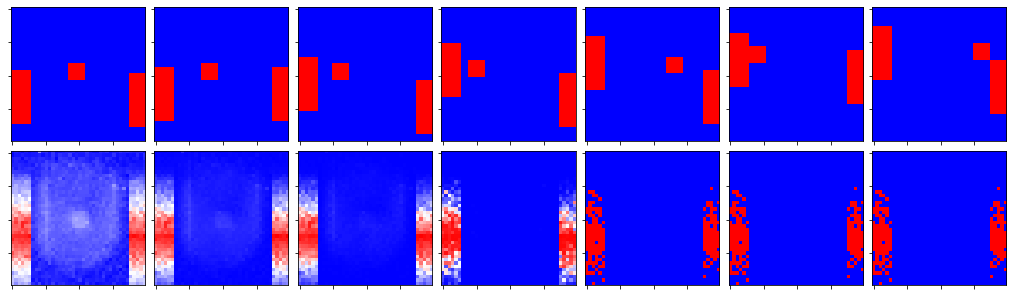

Epoch 3/2500
100/100 [==============================] - 47s 472ms/step - loss: 1.4631 - mean_squared_error: 0.1016 - acc: 0.8977 - val_loss: 1.5327 - val_mean_squared_error: 0.1056 - val_acc: 0.8934


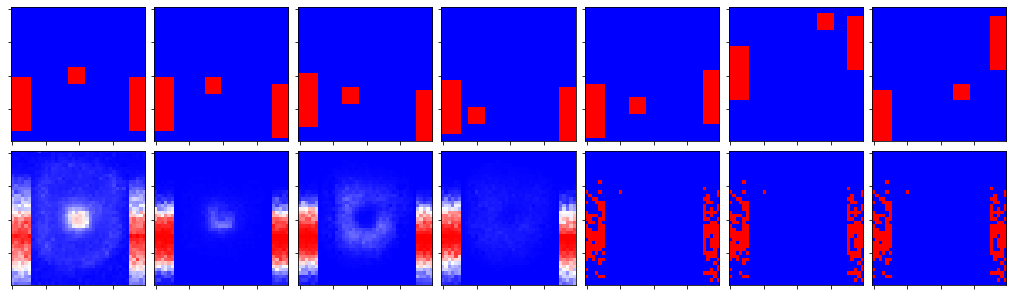

Epoch 4/2500
100/100 [==============================] - 49s 493ms/step - loss: 1.4663 - mean_squared_error: 0.1012 - acc: 0.8979 - val_loss: 1.4732 - val_mean_squared_error: 0.1011 - val_acc: 0.8978


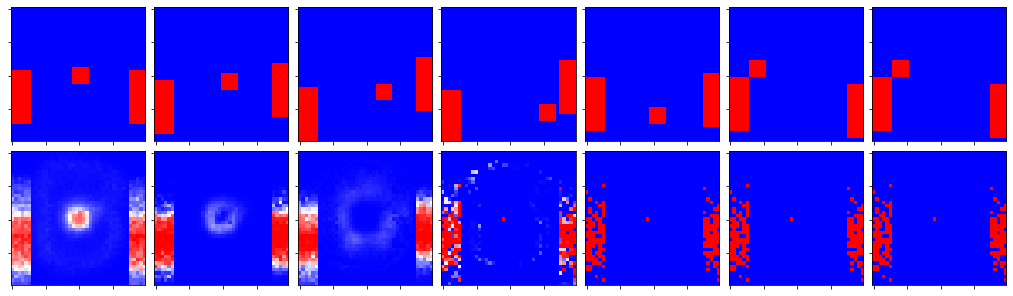

Epoch 5/2500
100/100 [==============================] - 49s 485ms/step - loss: 1.4426 - mean_squared_error: 0.0993 - acc: 0.8997 - val_loss: 1.3771 - val_mean_squared_error: 0.0954 - val_acc: 0.9033


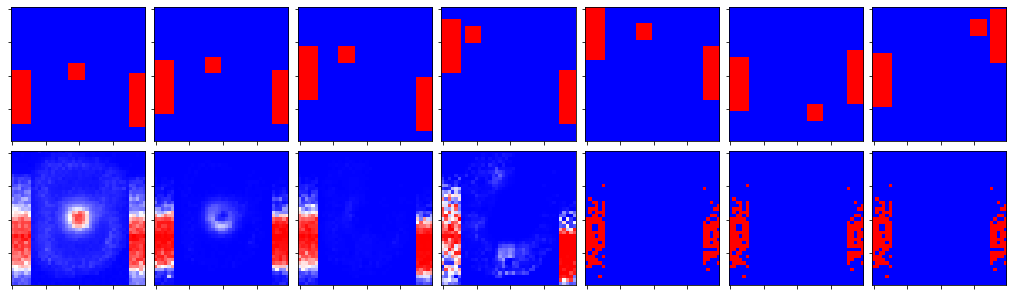

Epoch 6/2500
100/100 [==============================] - 49s 487ms/step - loss: 1.3977 - mean_squared_error: 0.0968 - acc: 0.9019 - val_loss: 1.3448 - val_mean_squared_error: 0.0936 - val_acc: 0.9049


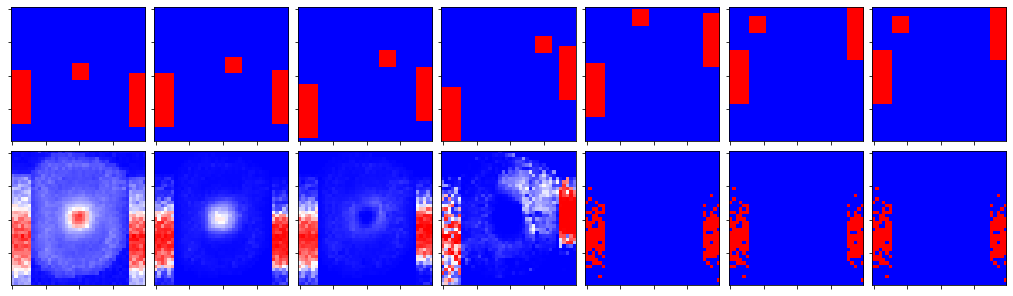

Epoch 7/2500
 31/100 [========>.....................] - ETA: 33s - loss: 1.3394 - mean_squared_error: 0.0933 - acc: 0.9051

In [ ]:
input_generator = make_dataset(bs=32)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=2500,
    callbacks=[PlotCallback()]
)

In [ ]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plot_pairwise_frames(frame_nums)

In [ ]:
stateful = model.copy_in_stateful_model()
stateful.init(0.4)
t = 0

stateful.net.save('STATEFUL_LSTM3_PONG_RELU_VARIED_INPUT.hdf5')

In [ ]:
t += 1
frame, _ = stateful.single_step_predict([-1, 1])

plt.imshow(frame > 0.01)
t